# Breast Cancer Imaging Analysis

HERE WE WILL IDENTIFY THE TYPE OF CALCIFICATION IN EACH IMAGE USING A FAST.AI ALGORITHM 

THERE ARE FOUR TYPES OF GENERAL ABNORMALITIES:
- PUNCTATE
- AMORPHOUS
- LUCENT / ROUND
- VASCULAR / FIBROUS 

THE GOAL IS TO CLASSIFY THE TYPE OF CALCIFICATION OBSERVED 

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
     |████████████████████████████████| 759.4MB 18kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'input/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.2.0.dev20190612
True
True


In [ ]:
!pip install fastai
!pip install fastai.vision

In [ ]:
# packages to import

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



from fastai import *
from fastai.vision import * 
from torchvision.models import *

**THERE ARE THREE DATASETS. HERE WE ONLY USE THE CALCIFICATION DATASET**

The path is found in the ROI mask file path column

In [ ]:
pathlib.Path('/content/gdrive/My Drive/input/train (1)') 


PosixPath('/content/gdrive/My Drive/input/train (1)')

In [ ]:
# Add images to Fast.ai

path = './gdrive/My Drive/input/'
train_path = './train/'
test_path = './test/'
train_labels = './train_labels_2.csv'
test_labels = './test_labels_multi_2.csv'



tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.2, max_zoom=1.1, max_lighting=0.1, p_affine=0.2)

np.random.seed(42)
data = ImageDataBunch.from_csv(path, csv_labels=train_labels, folder='train', valid_pct = 0.1,ds_tfms=tfms, size=224, test = 'test', suffix='.png', bs = 50)
stats=data.batch_stats()        
data.normalize(stats)


ImageDataBunch;

Train: LabelList (1391 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,amorphous,amorphous,vascular,vascular
Path: gdrive/My Drive/input;

Valid: LabelList (154 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,macro,macro,vascular,vascular
Path: gdrive/My Drive/input;

Test: LabelList (322 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: gdrive/My Drive/input

In [ ]:
data.batch_stats()

[tensor([0.1093, 0.1093, 0.1093]), tensor([1.0545, 1.0545, 1.0545])]

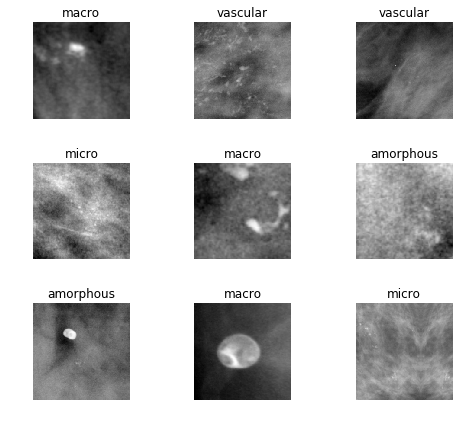

In [ ]:
data.show_batch(rows = 3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes), data.c

['amorphous', 'macro', 'micro', 'vascular']


(4, 4)

**Here, I used the simplest resnet model (resnet34) and used transfer learning to train the model on the new png images.**

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


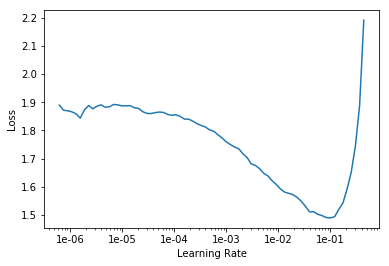

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.832954,1.521748,0.318182,00:28
1,1.627442,1.349231,0.409091,00:29
2,1.417438,1.114988,0.532468,00:29
3,1.282073,1.008260,0.590909,00:29
4,1.147864,0.961025,0.577922,00:29
5,1.044641,0.782808,0.668831,00:29
6,0.971095,0.789589,0.668831,00:30
7,0.908417,0.763112,0.707792,00:29
8,0.839563,0.765932,0.681818,00:28
9,0.781521,0.724307,0.701299,00:30


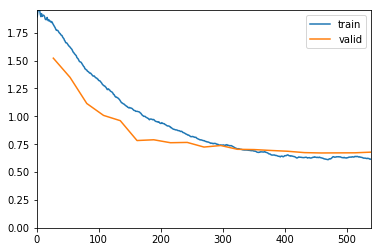

In [ ]:
learn.fit_one_cycle(20,1e-3 ,callbacks=[ShowGraph(learn),LearnerCallback(learn)])

In [ ]:
learn.save('resnet34-stage-1-n2')

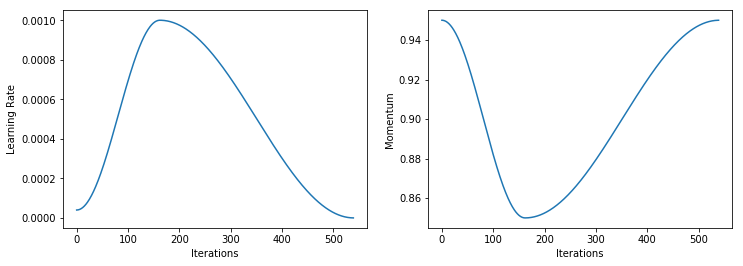

In [ ]:
learn.recorder.plot_lr(show_moms=True)

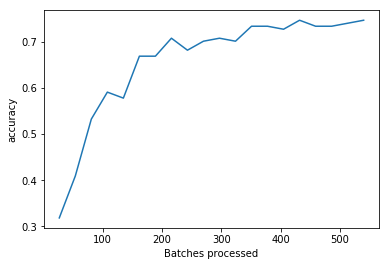

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

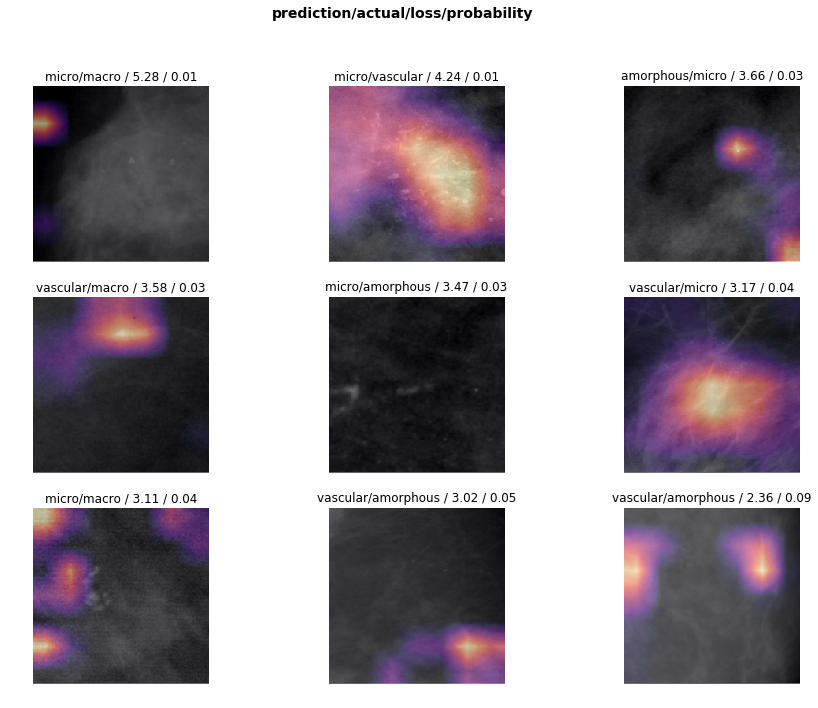

In [ ]:
interp.plot_top_losses(9,figsize=(15,11))

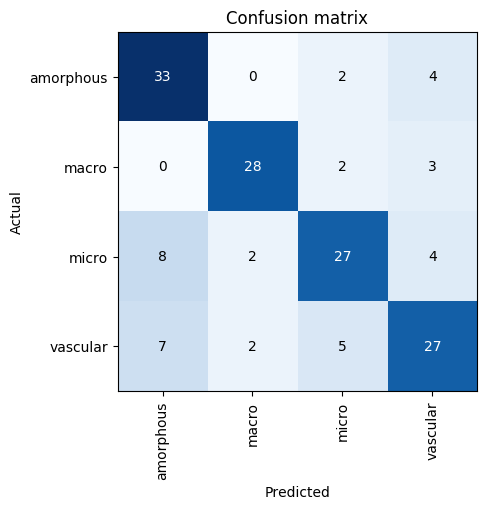

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi = 100)

In [ ]:
interp.most_confused(min_val = 2)

[('micro', 'amorphous', 8),
 ('vascular', 'amorphous', 7),
 ('vascular', 'micro', 5),
 ('amorphous', 'vascular', 4),
 ('micro', 'vascular', 4),
 ('macro', 'vascular', 3),
 ('amorphous', 'micro', 2),
 ('macro', 'micro', 2),
 ('micro', 'macro', 2),
 ('vascular', 'macro', 2)]

In [ ]:
learn.load('resnet34-stage-1-n2')

Learner(data=ImageDataBunch;

Train: LabelList (1391 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,amorphous,amorphous,vascular,vascular
Path: gdrive/My Drive/input;

Valid: LabelList (154 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,macro,macro,vascular,vascular
Path: gdrive/My Drive/input;

Test: LabelList (322 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: gdrive/My Drive/input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [ ]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


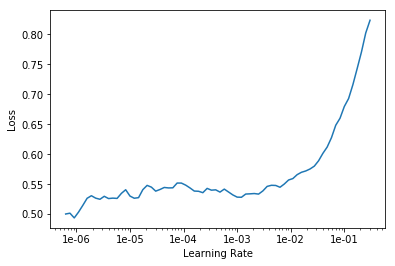

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.793240,0.730550,0.699029,0.528296,00:28
1,0.776819,0.734114,0.689320,0.514835,00:30
2,0.777215,0.738818,0.699029,0.522210,00:28
3,0.795138,0.731173,0.686084,0.525857,00:28
4,0.780859,0.740109,0.695793,0.524418,00:30


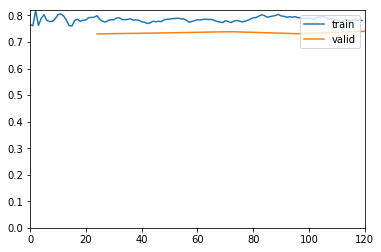

In [ ]:
# unfreeze the top layers and train the whole model.
learn.fit_one_cycle(5,max_lr = 1e-5, callbacks=[ShowGraph(learn),LearnerCallback(learn)])



epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.510128,0.729187,0.727273,0.532031,00:32
1,0.531361,0.731964,0.714286,0.520138,00:33
2,0.517910,0.736306,0.714286,0.515481,00:33
3,0.517753,0.722236,0.714286,0.512930,00:33
4,0.527581,0.724642,0.720779,0.520219,00:31


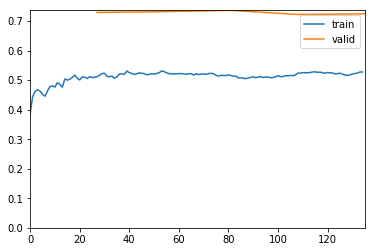

In [ ]:
learn.fit_one_cycle(5,max_lr = 1e-6, callbacks=[ShowGraph(learn),LearnerCallback(learn)])



In [ ]:
learn.load('resnet-stage-3-n2')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


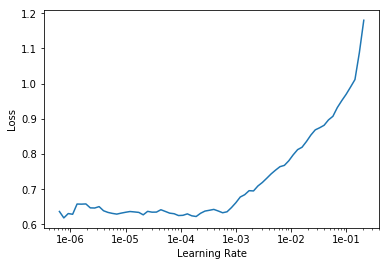

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.606871,0.678000,0.740260,00:31
1,0.606703,0.668839,0.759740,00:31
2,0.612144,0.676946,0.733766,00:31
3,0.611531,0.672426,0.733766,00:32
4,0.603743,0.676086,0.727273,00:31
5,0.587587,0.664620,0.759740,00:30
6,0.597108,0.674643,0.740260,00:32
7,0.585541,0.678132,0.733766,00:31
8,0.593416,0.670185,0.733766,00:32
9,0.577310,0.673435,0.740260,00:31


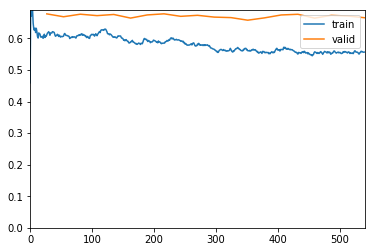

In [ ]:
learn.fit_one_cycle(20,max_lr = 1e-5/2, callbacks=[ShowGraph(learn),LearnerCallback(learn)])

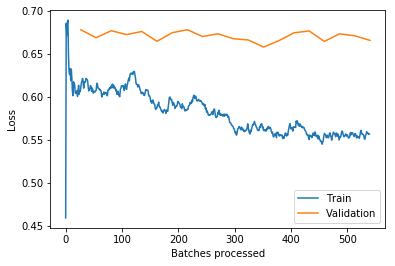

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


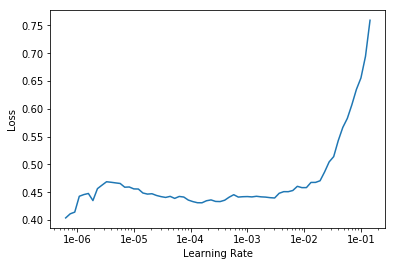

In [ ]:
learn.recorder.plot()

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


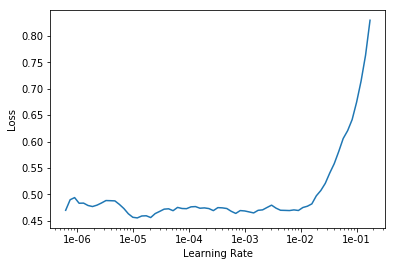

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.475587,0.661505,0.740260,00:30
1,0.472967,0.646702,0.753247,00:30
2,0.474857,0.659132,0.740260,00:30
3,0.472852,0.653140,0.753247,00:31


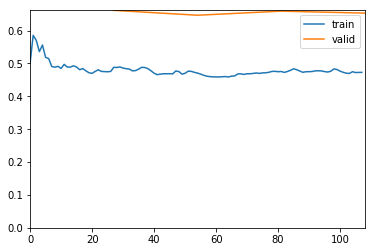

In [ ]:
learn.fit_one_cycle(4,max_lr = 1e-5/2, callbacks=[ShowGraph(learn),LearnerCallback(learn)])

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


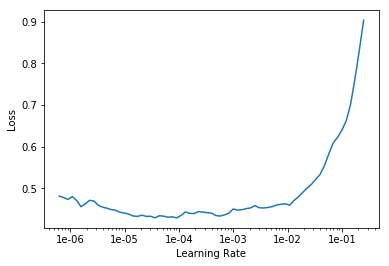

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.459317,0.665361,0.740260,00:29
1,0.463107,0.662306,0.746753,00:30
2,0.446796,0.656534,0.733766,00:30
3,0.452890,0.655711,0.746753,00:30
4,0.453460,0.654620,0.740260,00:29
5,0.453794,0.652424,0.753247,00:29
6,0.450570,0.653656,0.753247,00:30
7,0.454202,0.660772,0.753247,00:28
8,0.450881,0.651736,0.746753,00:30
9,0.455224,0.663544,0.733766,00:29


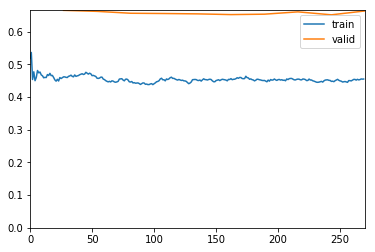

In [ ]:
learn.fit_one_cycle(10,max_lr = 1e-6, callbacks=[ShowGraph(learn),LearnerCallback(learn)])

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


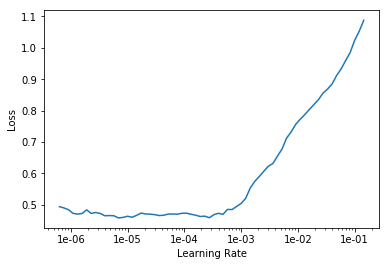

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.478722,0.654284,0.740260,00:29
1,0.435164,0.644919,0.746753,00:29
2,0.439230,0.643645,0.740260,00:29
3,0.445418,0.645019,0.746753,00:29
4,0.443170,0.641434,0.746753,00:29


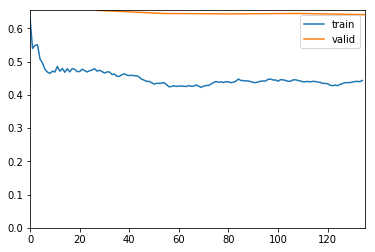

In [ ]:
learn.fit_one_cycle(5,max_lr = 1e-6, callbacks=[ShowGraph(learn),LearnerCallback(learn)])



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

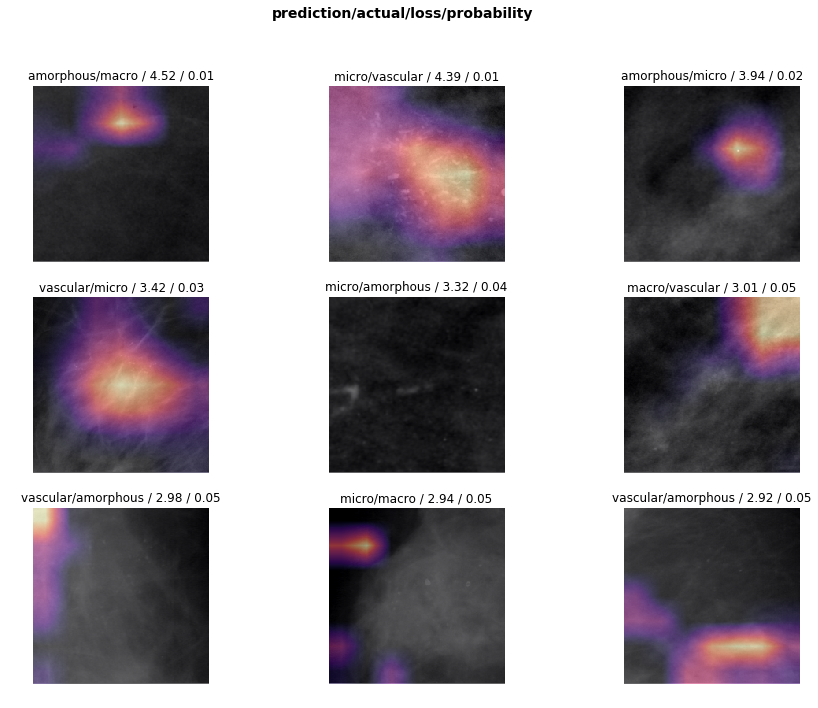

In [ ]:
interp.plot_top_losses(9,figsize=(15,11))

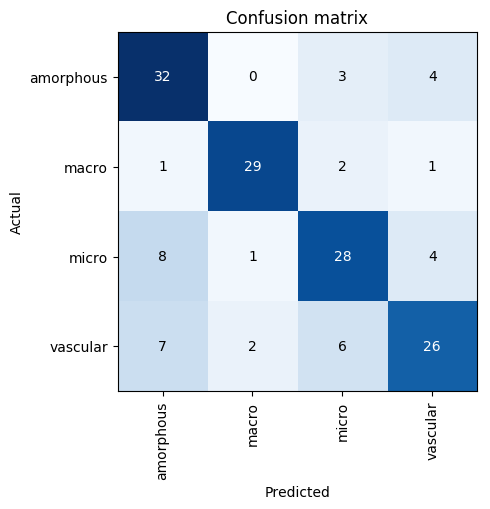

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi = 100)

In [ ]:
interp.most_confused(min_val = 2)

[('micro', 'amorphous', 8),
 ('vascular', 'amorphous', 7),
 ('vascular', 'micro', 6),
 ('amorphous', 'vascular', 4),
 ('micro', 'vascular', 4),
 ('amorphous', 'micro', 3),
 ('macro', 'micro', 2),
 ('vascular', 'macro', 2)]

In [ ]:
learn.save('stage-final')

In [ ]:
learn.load('stage-final')

Learner(data=ImageDataBunch;

Train: LabelList (1391 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,amorphous,amorphous,vascular,vascular
Path: gdrive/My Drive/input;

Valid: LabelList (154 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
amorphous,macro,macro,vascular,vascular
Path: gdrive/My Drive/input;

Test: LabelList (322 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: gdrive/My Drive/input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [ ]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.7077922224998474 %.


### Get highest predicted label only 

In [ ]:
preds_1, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y_pred_1 = torch.argmax(preds_1, dim=1)

In [ ]:
y_pred_1

tensor([2, 3, 2, 1, 0, 0, 1, 1, 2, 0, 3, 0, 3, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2,
        2, 2, 3, 1, 3, 3, 2, 1, 0, 0, 2, 2, 3, 0, 3, 3, 1, 1, 2, 1, 0, 2, 1, 3,
        0, 0, 2, 3, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 3, 2, 2, 3, 3, 1, 2, 2, 0,
        2, 1, 2, 1, 0, 3, 3, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 1, 0,
        1, 2, 1, 3, 1, 3, 3, 2, 1, 2, 2, 3, 0, 1, 0, 2, 2, 0, 2, 0, 2, 1, 3, 2,
        0, 3, 3, 2, 0, 0, 2, 3, 3, 1, 2, 0, 1, 1, 2, 1, 0, 0, 3, 2, 0, 3, 2, 2,
        0, 3, 2, 2, 3, 0, 2, 2, 0, 0, 0, 2, 1, 2, 3, 3, 2, 3, 2, 1, 1, 0, 2, 0,
        3, 2, 0, 1, 1, 2, 3, 0, 0, 2, 2, 1, 1, 2, 0, 0, 3, 2, 2, 0, 1, 2, 3, 1,
        2, 2, 0, 2, 0, 3, 0, 2, 1, 0, 2, 3, 3, 2, 1, 2, 2, 0, 3, 2, 2, 2, 1, 3,
        1, 0, 3, 0, 1, 1, 3, 0, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2,
        3, 0, 2, 2, 1, 2, 0, 0, 3, 0, 3, 2, 1, 2, 1, 2, 3, 3, 0, 3, 0, 3, 2, 2,
        3, 2, 1, 0, 2, 3, 2, 3, 2, 2, 3, 0, 2, 2, 3, 2, 0, 2, 2, 0, 1, 1, 3, 2,
        2, 1, 1, 2, 0, 1, 3, 0, 2, 0, 3,

In [ ]:
# tensor to numpu array
y_pred_1 = to_np(y_pred_1)

In [ ]:
y_pred_1

array([2, 3, 2, 1, ..., 2, 3, 0, 2])

In [ ]:
test_labels = pd.read_csv('./gdrive/My Drive/input/test_labels_multi_2.csv')
test_labels['label'].replace('amorphous', 0, inplace = True)
test_labels['label'].replace('macro', 1, inplace = True)
test_labels['label'].replace('vascular', 3, inplace = True)
test_labels['label'].replace('micro', 2, inplace = True)

**Re-organizing the image labels and the predicted labels**

In [ ]:
file_names = []
for i in range(len(data.test_ds.x.items)):
    link = str(data.test_ds.x.items[i])
    file_names.append(link)
    
test_names = pd.DataFrame(file_names)
links_df = test_names[0].str.split("/", n = 5, expand = True) 
links_df.columns = ['gdrive','My Drive','input', 'test', 'image_name']
links_df['image_name'] = links_df['image_name'].str[:-4]

links_df = links_df[['image_name']]
links_df['y_preds'] = y_pred
links_df = links_df.sort_values(by = ['image_name'])

links_df.reset_index(drop=True, inplace = True)
      
links_df['y_true'] = test_labels['label']

links_df['y_true'] = test_labels['label']

In [ ]:
links_df_['y_preds'] = y_pred_1

In [ ]:
links_df_

,image_name,pct,amorphous,macro,micro,vascular,y_preds
0,Calc-Test_P_01471_RIGHT_MLO_1,0,0,0,0,0,2
1,Calc-Test_P_00589_LEFT_CC_1,0,0,0,0,0,3
2,Calc-Test_P_00150_RIGHT_MLO_1,0,0,0,0,0,2
3,Calc-Test_P_01006_LEFT_MLO_1,0,0,0,0,0,1
4,Calc-Test_P_00495_RIGHT_MLO_3,0,0,0,0,0,0
5,Calc-Test_P_01353_LEFT_CC_1,0,0,0,0,0,0
6,Calc-Test_P_01407_LEFT_MLO_1,0,0,0,0,0,1
7,Calc-Test_P_01842_LEFT_MLO_1,0,0,0,0,0,1
8,Calc-Test_P_01237_LEFT_MLO_1,0,0,0,0,0,2
9,Calc-Test_P_00195_LEFT_CC_1,0,0,0,0,0,0


In [ ]:
y_true = links_df['y_true'].values

In [ ]:
y_pred = links_df['y_preds'].values

In [ ]:
# caculatate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


0.7919254658385093

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[58,  1, 17,  6],
       [ 0, 53,  1,  2],
       [16,  3, 98, 11],
       [ 3,  0,  7, 46]])

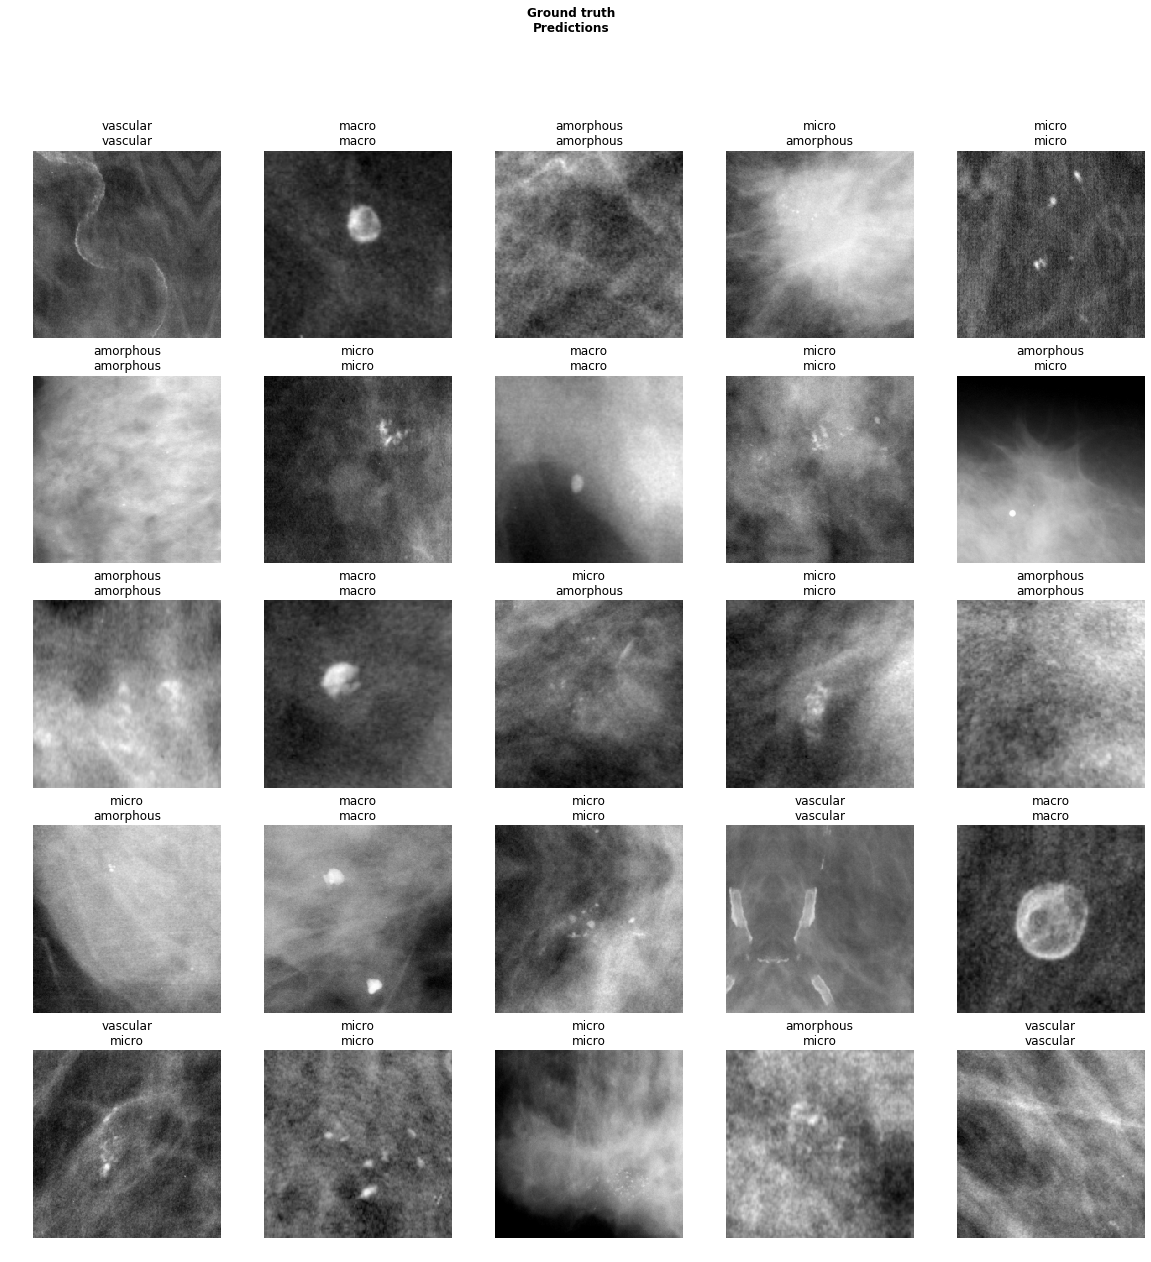

In [ ]:
learn.show_results(ds_type=DatasetType.Train)

### Get the percentage for each predicted label

In [ ]:
preds_arg, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)

In [ ]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)


In [ ]:
y_pred = to_np(preds)

print(y_pred, type(y_pred))

[[1.844059e-01 1.135078e-02 8.003119e-01 3.931532e-03]
 [1.626623e-01 2.804551e-02 3.510070e-01 4.582853e-01]
 [1.214420e-02 1.121267e-03 9.774716e-01 9.262925e-03]
 [1.231029e-02 9.853927e-01 1.514315e-03 7.826965e-04]
 ...
 [1.133325e-03 6.240916e-04 5.316653e-01 4.665774e-01]
 [6.311377e-02 2.022034e-02 3.496975e-01 5.669684e-01]
 [3.744060e-01 6.978963e-02 2.900316e-01 2.657728e-01]
 [2.828609e-01 2.756057e-03 3.776539e-01 3.367291e-01]] <class 'numpy.ndarray'>


In [ ]:
links_df_['amorphous']= 0
links_df_['macro'] = 0
links_df_['micro'] = 0
links_df_['vascular'] = 0

In [ ]:
links_df_['amorphous'][0]

0

In [ ]:
for i in range(len(links_df_)):
    links_df_.loc[i,'amorphous'] = y_pred[i][0]
    links_df_.loc[i,'macro'] = y_pred[i][1]
    links_df_.loc[i,'micro'] = y_pred[i][2]
    links_df_.loc[i,'vascular'] = y_pred[i][3]

In [ ]:
links_df_ = links_df_.sort_values(by = 'image_name')

In [ ]:
links_df_.drop(columns = ['pct'],inplace =True)

In [ ]:
links_df_.reset_index(drop = True, inplace = True)

In [ ]:
links_df[links_df_['y_preds'] != links_df_['y_true']]

,image_name,amorphous,macro,micro,vascular,y_preds,y_true
1,Calc-Test_P_00038_LEFT_MLO_1,0.064083,0.007815,0.059483,0.868620,3,1
2,Calc-Test_P_00038_RIGHT_CC_1,0.018465,0.014155,0.020063,0.947317,3,0
3,Calc-Test_P_00038_RIGHT_CC_2,0.181259,0.001020,0.005427,0.812294,3,2
4,Calc-Test_P_00038_RIGHT_MLO_1,0.001786,0.000323,0.010513,0.987378,3,2
6,Calc-Test_P_00041_LEFT_CC_2,0.000156,0.995309,0.001947,0.002588,1,2
7,Calc-Test_P_00041_LEFT_MLO_2,0.000345,0.992392,0.000498,0.006766,1,3
8,Calc-Test_P_00077_LEFT_CC_1,0.000800,0.996225,0.001759,0.001215,1,0
12,Calc-Test_P_00077_RIGHT_MLO_1,0.002471,0.786934,0.003916,0.206680,1,2
13,Calc-Test_P_00077_RIGHT_MLO_2,0.032447,0.022350,0.941155,0.004047,2,1
14,Calc-Test_P_00100_RIGHT_CC_1,0.857435,0.021761,0.102231,0.018573,0,2


### Samples Mis-labeled 

In [ ]:
y_pred[255]

array([6.603042e-03, 3.877194e-04, 8.292645e-01, 1.637447e-01], dtype=float32)

In [ ]:
test_names[0][255]

'gdrive/My Drive/input/test/Calc-Test_P_01803_RIGHT_MLO_1.png'

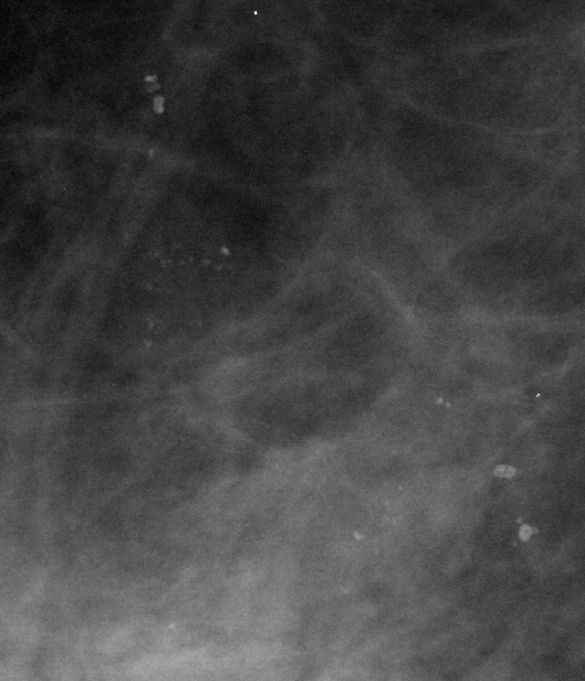

In [ ]:
data.open(test_names[0][255])

Text(0, 0.5, 'Probability')

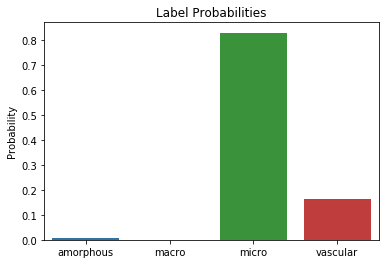

In [ ]:
import seaborn as sns
sns.barplot(x = ['amorphous', 'macro', 'micro', 'vascular'], y = y_pred[255])
plt.title('Label Probabilities')
plt.ylabel('Probability')

In [ ]:
y_pred[318]

array([0.001027, 0.000695, 0.536048, 0.46223 ], dtype=float32)

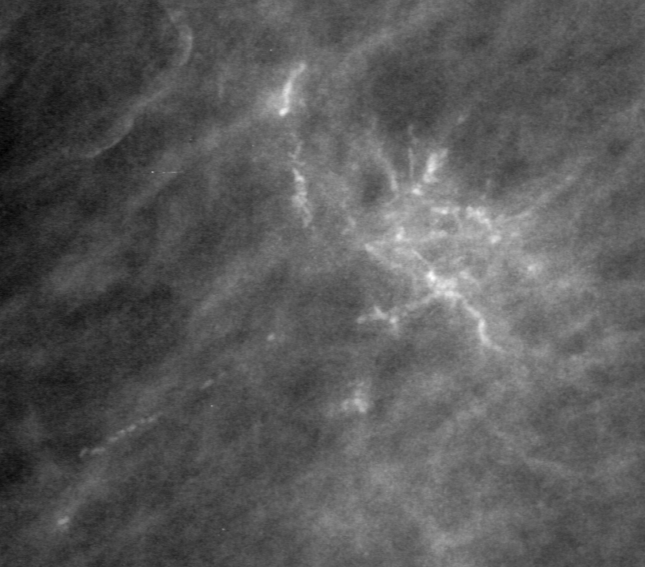

In [ ]:
data.open(test_names[0][318])

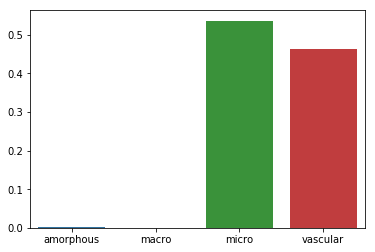

In [ ]:
import seaborn as sns
sns.barplot(x = ['amorphous', 'macro', 'micro', 'vascular'], y = y_pred[318])